# Chess Anti-Cheat Dataset Analysis

This notebook provides comprehensive visualizations and analysis of a chess anti-cheat dataset where ground-truth cheating labels are known.

## Terminology

| Term | Definition | Column(s) |
|------|------------|-----------|
| **Hint event** | Player requested and saw engine suggestions | `*_hint_displayed=True`, `*_engine_hints` not null |
| **Cheating-labeled move** | Move informed by engine hints (including PV continuation) | `move_label=1` |
| **Engine-match move** | Cheating move that matched a displayed hint | `cheat_engine_line∈{1..5}` |

## Prediction Tasks

| Task | Unit | Target | Description |
|------|------|--------|-------------|
| **Move-level** | Single move | `move_label` | Was this move informed by engine assistance? |
| **Player-game-level** | (player, game) pair | `white_cheat_game` / `black_cheat_game` | Did this player cheat in this game? |
| **Game-level** | Game | `white_cheat_game OR black_cheat_game` | Was there any cheating in this game? |

## Label Used: `move_label`
This notebook uses the **extended cheating label** which includes:
- Direct hint usage (`move_label=1`)
- PV continuation moves (player follows memorized engine line)

## Dataset Statistics
- 49 players across 2 tournaments
- 505 games, ~40,000 moves
- ~31% of moves are cheating-labeled (`move_label=1`)
- Ground-truth labels enable rigorous baseline evaluation

In [2]:
# === Imports ===
import os
import ast
from pathlib import Path

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

# === Display settings ===
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# === Plot settings ===
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "sans-serif"

# === Create figures directory ===
Path("figures").mkdir(exist_ok=True)

# === Unified Color Palette (Colorblind-Friendly) ===
# Based on IBM Design / Wong palette - safe for deuteranopia, protanopia, tritanopia

# Primary colors (colorblind-safe)
COLOR_FAIR = '#009E73'       # Bluish green - fair play
COLOR_CHEAT = '#D55E00'      # Vermillion/orange - cheating
COLOR_NEUTRAL = '#0072B2'    # Blue - neutral, reference
COLOR_WARNING = '#E69F00'    # Orange/yellow - warning
COLOR_GRAY = '#999999'       # Gray - neutral, disabled
COLOR_DARK = '#000000'       # Black - edges, text

# Extended palette for categories
COLORS_FAIR_CHEAT = [COLOR_FAIR, COLOR_CHEAT]
COLORS_3CAT = [COLOR_FAIR, COLOR_WARNING, COLOR_CHEAT]  # Fair, Mixed, Cheat

# Rating bins (5 bins: sequential blue palette - colorblind safe)
COLORS_RATING = ['#c6dbef', '#9ecae1', '#6baed6', '#3182bd', '#08519c']

# Rating bins (3 bins)
COLORS_RATING_3 = ['#9ecae1', '#3182bd', '#08519c']  # Weak, Medium, Strong

# Baseline colors (colorblind-safe distinct colors)
COLORS_BASELINES = [COLOR_GRAY, COLOR_NEUTRAL, '#CC79A7', COLOR_CHEAT]  # Gray, Blue, Pink, Orange

# Heatmap colormaps (colorblind-friendly)
CMAP_PROBABILITY = 'OrRd'    # Orange-Red (safe)
CMAP_INTENSITY = 'YlOrBr'    # Yellow-Orange-Brown (safe)
CMAP_NEUTRAL = 'Blues'       # Blues (safe)

# Edge and text colors
COLOR_EDGE = '#000000'
COLOR_TEXT = '#000000'

# === Font sizes for readability ===
FONTSIZE_TITLE = 22
FONTSIZE_LABEL = 20
FONTSIZE_TICK = 18
FONTSIZE_LEGEND = 18
FONTSIZE_ANNOT = 16

# Apply default font sizes
plt.rcParams.update({
    'font.size': FONTSIZE_TICK,
    'axes.titlesize': FONTSIZE_TITLE,
    'axes.labelsize': FONTSIZE_LABEL,
    'xtick.labelsize': FONTSIZE_TICK,
    'ytick.labelsize': FONTSIZE_TICK,
    'legend.fontsize': FONTSIZE_LEGEND,
    'figure.titlesize': FONTSIZE_TITLE
})


**Rating distribution of tournament participants.**

The dataset spans a wide range of playing strengths. The table above shows the exact distribution across rating bins.

| Metric | Value |
|--------|-------|
| Rating source | Chess.com blitz (Lichess fallback) |
| Range | ~900 to ~2800 |
| Distribution | Right-skewed (more intermediate players) |

**Key insight:** The diverse skill distribution enables analysis of how cheating behavior varies with player strength. Stronger players (>2000) make up a significant portion, providing robust data for high-level play patterns.

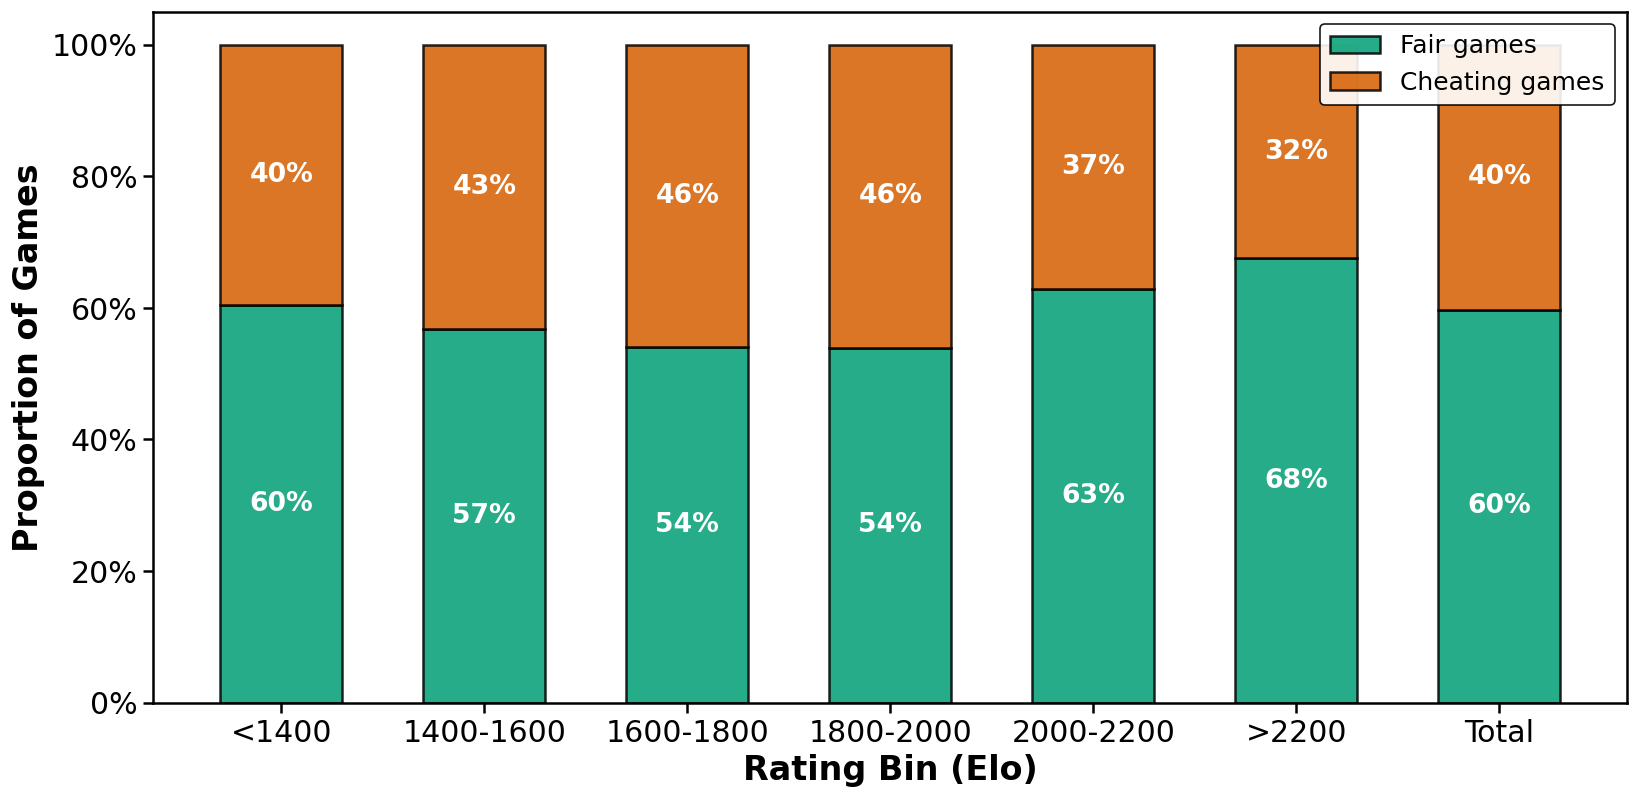

| Rating Bin | Fair | Cheat | Total | Cheat % |
|------------|------|-------|-------|---------|
| <1400 | 26 | 17 | 43 | 39.5% |
| 1400-1600 | 54 | 41 | 95 | 43.2% |
| 1600-1800 | 107 | 91 | 198 | 46.0% |
| 1800-2000 | 123 | 105 | 228 | 46.1% |
| 2000-2200 | 110 | 65 | 175 | 37.1% |
| >2200 | 183 | 88 | 271 | 32.5% |
| **Total** | 603 | 407 | 1010 | 40.3% |


In [7]:
# Games per rating bin (normalized: proportion of fair vs cheating)
player_elo_map = dict(zip(elo_combined['original_player'], elo_combined['elo_bin']))

# Prepare game-level data with bins
games_with_bins = []
for _, game in game_result_combined.iterrows():
    white_bin = player_elo_map.get(game['white_player'])
    black_bin = player_elo_map.get(game['black_player'])
    
    if white_bin is not None:
        games_with_bins.append({'player_bin': white_bin, 'cheated': game['white_cheated']})
    if black_bin is not None:
        games_with_bins.append({'player_bin': black_bin, 'cheated': game['black_cheated']})

games_df = pd.DataFrame(games_with_bins)

# Count games by bin and cheating status
games_count = games_df.groupby(['player_bin', 'cheated']).size().unstack(fill_value=0)
games_count = games_count.reindex(labels, fill_value=0)

# Calculate proportions
totals = games_count[False] + games_count[True]
fair_prop = games_count[False] / totals
cheat_prop = games_count[True] / totals

# Add total column
total_fair = games_count[False].sum()
total_cheat = games_count[True].sum()
total_all = total_fair + total_cheat

labels_with_total = labels + ['Total']

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(labels_with_total))
width = 0.6  # Wider for stacked bars

# Proportions with total
fair_values = list(fair_prop) + [total_fair / total_all]
cheat_values = list(cheat_prop) + [total_cheat / total_all]

# Stacked bars (proportions sum to 1)
bars_fair = ax.bar(x, fair_values, width, label='Fair games', color=COLOR_FAIR, edgecolor='black', alpha=0.85, linewidth=1.5)
bars_cheat = ax.bar(x, cheat_values, width, bottom=fair_values, label='Cheating games', color=COLOR_CHEAT, edgecolor='black', alpha=0.85, linewidth=1.5)

# Add percentage labels on bars
for i, (f, c) in enumerate(zip(fair_values, cheat_values)):
    if f > 0.08:  # Only show if bar is big enough
        ax.text(i, f/2, f'{f*100:.0f}%', ha='center', va='center', fontsize=FONTSIZE_ANNOT, fontweight='bold', color='white')
    if c > 0.08:
        ax.text(i, f + c/2, f'{c*100:.0f}%', ha='center', va='center', fontsize=FONTSIZE_ANNOT, fontweight='bold', color='white')

ax.set_xlabel('Rating Bin (Elo)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('Proportion of Games', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels_with_total, rotation=0, fontsize=FONTSIZE_TICK)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK, width=1.5, length=6)
ax.legend(fontsize=15, framealpha=0.9, edgecolor='black', loc='upper right')
ax.set_ylim(0, 1.05)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/games_per_bin.pdf', bbox_inches='tight')
plt.show()

# Print statistics as markdown table
print("| Rating Bin | Fair | Cheat | Total | Cheat % |")
print("|------------|------|-------|-------|---------|")
for i, label in enumerate(labels):
    fair = games_count[False].iloc[i]
    cheat = games_count[True].iloc[i]
    total = fair + cheat
    pct = cheat / total * 100 if total > 0 else 0
    print(f"| {label} | {fair} | {cheat} | {total} | {pct:.1f}% |")
print(f"| **Total** | {total_fair} | {total_cheat} | {total_all} | {total_cheat/total_all*100:.1f}% |")

**Distribution of games per rating bin, stratified by cheating behavior.**

Green bars indicate games with at least one cheating move; blue bars show fair games. The proportion of cheating games remains relatively stable across rating bins, suggesting that the temptation to cheat is not strongly correlated with skill level in this controlled experiment.

**Key insight:** Cheating prevalence (~40-50% of games) is consistent across all skill levels, contradicting the hypothesis that weaker players cheat more frequently.

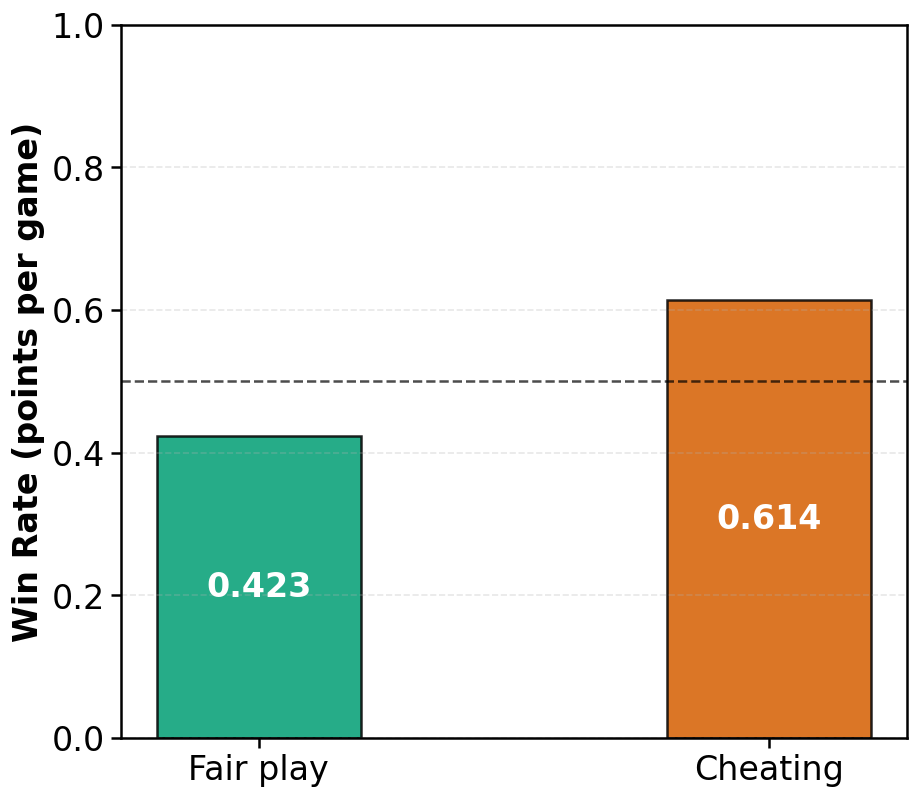

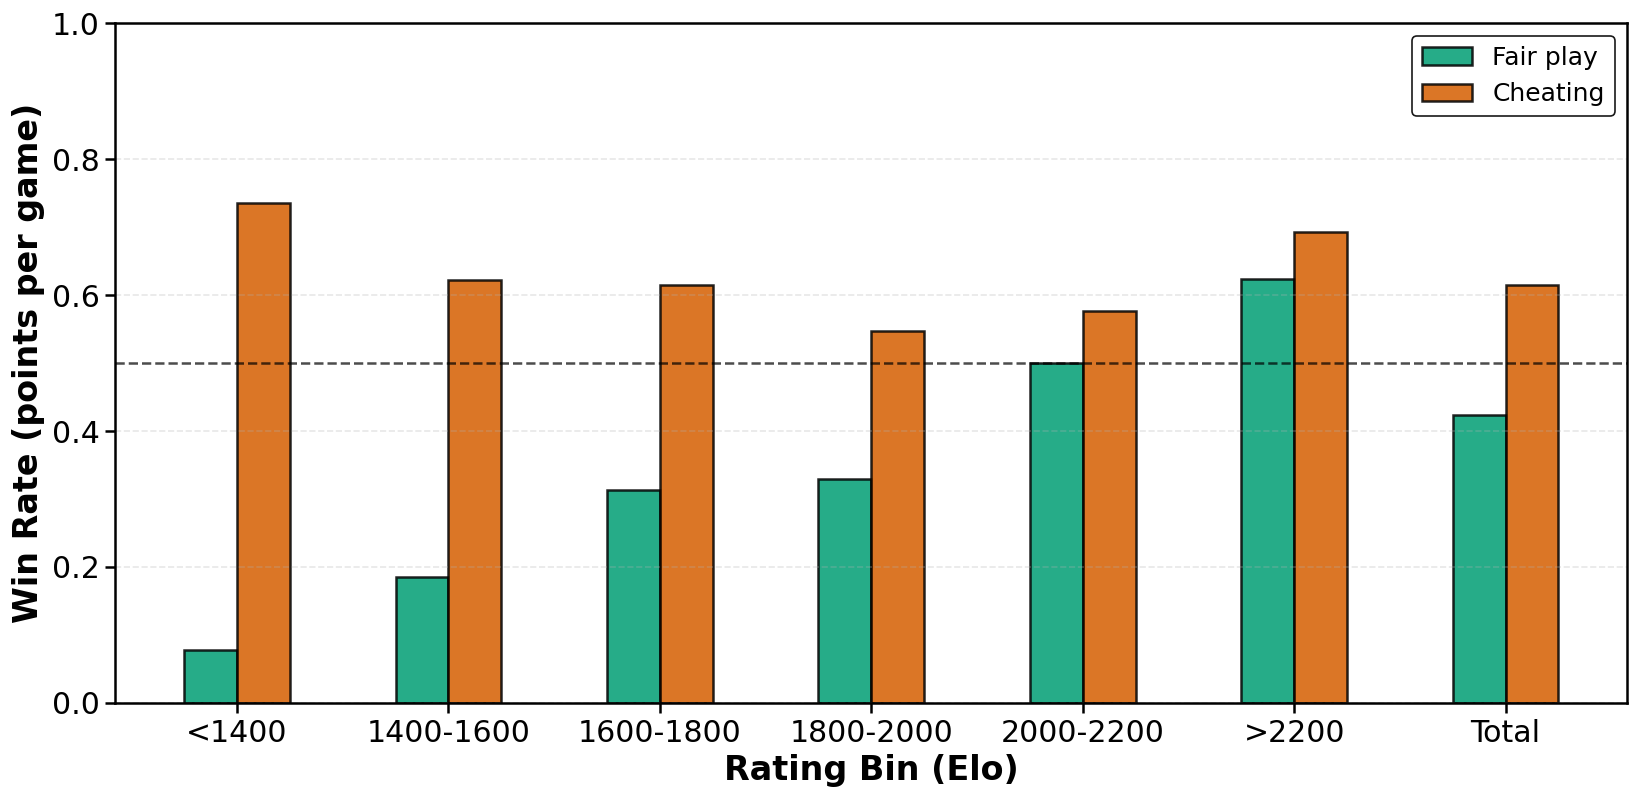


Win rate statistics by Elo bin:
  Elo bin    n  n_fair  n_cheat  s_fair  s_cheat  delta
    <1400   43      26       17   0.077    0.735  0.658
1400-1600   95      54       41   0.185    0.622  0.437
1600-1800  198     107       91   0.313    0.615  0.302
1800-2000  228     123      105   0.329    0.548  0.218
2000-2200  175     110       65   0.500    0.577  0.077
    >2200  271     183       88   0.623    0.693  0.070
    Total 1010     603      407   0.423    0.614  0.191


In [8]:
# Win-rate / points: cheating vs fair - SEPARATE FIGURES
# Prepare data with game outcomes
game_outcomes = []
for _, game in game_result_combined.iterrows():
    white_bin = player_elo_map.get(game['white_player'])
    black_bin = player_elo_map.get(game['black_player'])
    
    # White's perspective
    if white_bin is not None:
        if game['result_white'] == 'win':
            points = 1.0
        elif game['result_white'] == 'draw':
            points = 0.5
        else:
            points = 0.0
        
        game_outcomes.append({
            'player_bin': white_bin,
            'cheated': game['white_cheated'],
            'points': points
        })
    
    # Black's perspective
    if black_bin is not None:
        if game['result_white'] == 'loss':
            points = 1.0
        elif game['result_white'] == 'draw':
            points = 0.5
        else:
            points = 0.0
        
        game_outcomes.append({
            'player_bin': black_bin,
            'cheated': game['black_cheated'],
            'points': points
        })

outcomes_df = pd.DataFrame(game_outcomes)

# Calculate win rates
winrate_by_cheat = outcomes_df.groupby('cheated')['points'].mean()
winrate_by_bin = outcomes_df.groupby(['player_bin', 'cheated'])['points'].mean().unstack(fill_value=0)
winrate_by_bin = winrate_by_bin.reindex(labels, fill_value=0)

# ===== FIGURE A: Overall win rate =====
fig, ax1 = plt.subplots(figsize=(8, 7))

categories = ['Fair play', 'Cheating']
win_rates = [winrate_by_cheat[False], winrate_by_cheat[True]]
colors_global = [COLOR_FAIR, COLOR_CHEAT]

bars1 = ax1.bar(categories, win_rates, color=colors_global, edgecolor='black', alpha=0.85, width=0.4, linewidth=1.5)
ax1.set_ylabel('Win Rate (points per game)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.7)  # Horizontal line at 0.5
ax1.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABEL, width=1.5, length=6)
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)

# Add value labels inside bars
for i, (bar, v) in enumerate(zip(bars1, win_rates)):
    ax1.text(i, v/2, f'{v:.3f}', ha='center', va='center', fontweight='bold', fontsize=FONTSIZE_LABEL, color='white')

for spine in ax1.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/winrate_overall.pdf', bbox_inches='tight')
plt.show()

# ===== FIGURE B: Win rate by bin with TOTAL column =====
fig, ax2 = plt.subplots(figsize=(14, 7))

# Add total column
labels_with_total = labels + ['Total']
fair_values = list(winrate_by_bin[False]) + [winrate_by_cheat[False]]
cheat_values = list(winrate_by_bin[True]) + [winrate_by_cheat[True]]

x = np.arange(len(labels_with_total))
width = 0.25  # Narrower bars

bars_fair = ax2.bar(x - width/2, fair_values, width, label='Fair play', 
                     color=COLOR_FAIR, edgecolor='black', alpha=0.85, linewidth=1.5)
bars_cheat = ax2.bar(x + width/2, cheat_values, width, label='Cheating', 
                      color=COLOR_CHEAT, edgecolor='black', alpha=0.85, linewidth=1.5)

ax2.set_xlabel('Rating Bin (Elo)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax2.set_ylabel('Win Rate (points per game)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels_with_total, rotation=0, fontsize=FONTSIZE_LABEL)
ax2.set_ylim(0, 1.0)
ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.7)  # Horizontal line at 0.5
ax2.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK, width=1.5, length=6)
ax2.legend(fontsize=15, framealpha=0.9, edgecolor='black')
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)

for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/winrate_by_bin.pdf', bbox_inches='tight')
plt.show()

# ===== TABLE: Statistics by Elo bin =====
# Compute counts and means for each bin
table_data = []
for bin_label in labels:
    bin_data = outcomes_df[outcomes_df['player_bin'] == bin_label]
    n = len(bin_data)
    n_fair = len(bin_data[~bin_data['cheated']])
    n_cheat = len(bin_data[bin_data['cheated']])
    s_fair = bin_data[~bin_data['cheated']]['points'].mean() if n_fair > 0 else 0
    s_cheat = bin_data[bin_data['cheated']]['points'].mean() if n_cheat > 0 else 0
    delta = s_cheat - s_fair if n_fair > 0 and n_cheat > 0 else np.nan
    table_data.append({'Elo bin': bin_label, 'n': n, 'n_fair': n_fair, 'n_cheat': n_cheat,
                       's_fair': s_fair, 's_cheat': s_cheat, 'delta': delta})

# Add total row
n_total = len(outcomes_df)
n_fair_total = len(outcomes_df[~outcomes_df['cheated']])
n_cheat_total = len(outcomes_df[outcomes_df['cheated']])
s_fair_total = outcomes_df[~outcomes_df['cheated']]['points'].mean()
s_cheat_total = outcomes_df[outcomes_df['cheated']]['points'].mean()
delta_total = s_cheat_total - s_fair_total
table_data.append({'Elo bin': 'Total', 'n': n_total, 'n_fair': n_fair_total, 'n_cheat': n_cheat_total,
                   's_fair': s_fair_total, 's_cheat': s_cheat_total, 'delta': delta_total})

winrate_table = pd.DataFrame(table_data)
print('\nWin rate statistics by Elo bin:')
print(winrate_table.to_string(index=False, float_format=lambda x: f'{x:.3f}' if pd.notna(x) else '-'))


**Cheating intensity: distribution of cheating-labeled moves per cheating game.**

This boxplot shows the distribution of how many cheating moves players make per game when they choose to cheat. The boxes show interquartile range (IQR), whiskers extend to 1.5×IQR, and diamond markers indicate the mean.

**Key insight:** Weaker players (<1600) show higher median cheating intensity and greater variability. Stronger players (>2000) tend to be more selective, using fewer engine moves per game with less spread.

/tmp/ipykernel_269583/2680463650.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(box_data, labels=labels, patch_artist=True, widths=0.5,


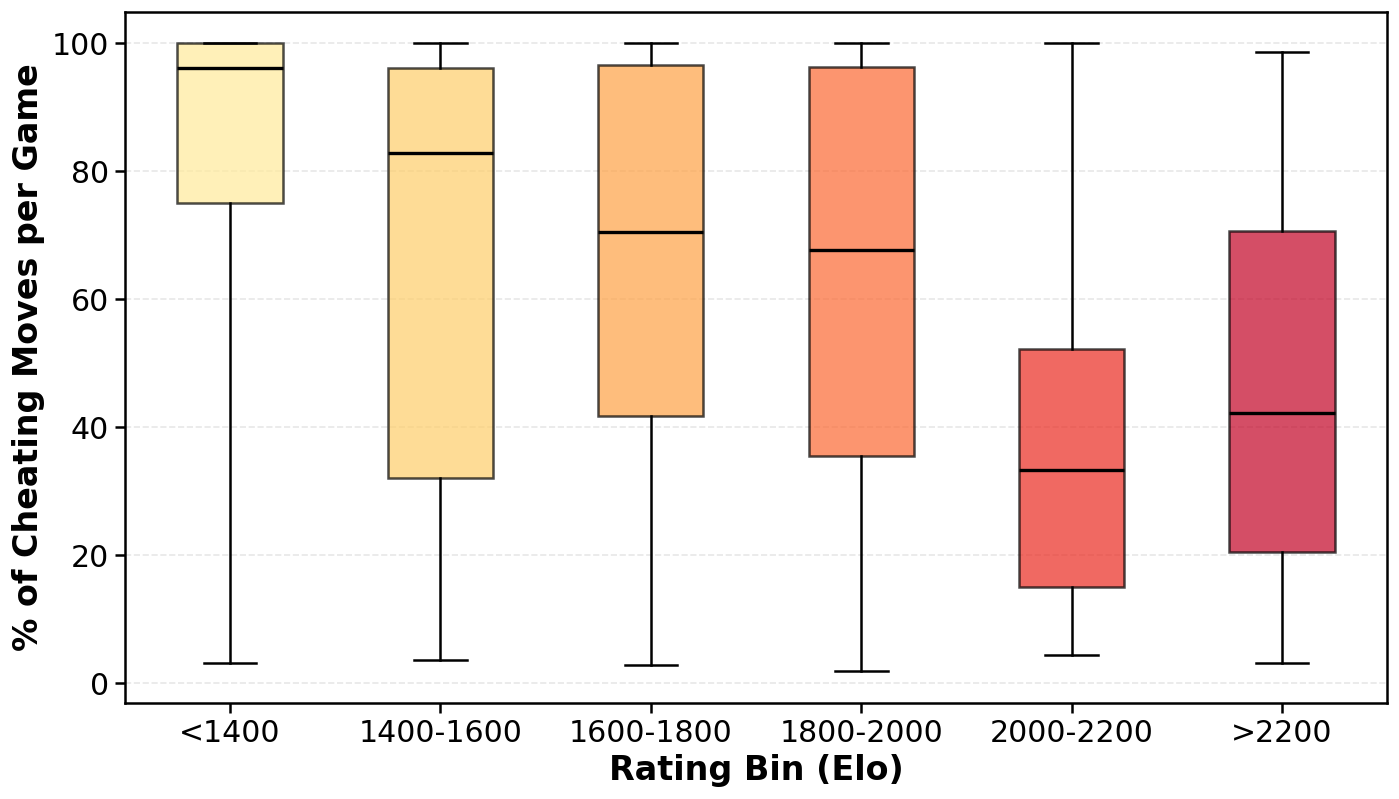


=== Cheating % per game statistics ===
Bin                 Mean   Median    Min    Max     Q1     Q3     N
----------------------------------------------------------------------
<1400               81.9     96.2    3.1  100.0   75.0  100.0    17
1400-1600           67.4     82.9    3.6  100.0   32.0   96.2    41
1600-1800           65.1     70.5    2.9  100.0   41.7   96.6    91
1800-2000           63.5     67.7    1.9  100.0   35.5   96.3   105
2000-2200           38.8     33.3    4.3  100.0   15.1   52.2    65
>2200               45.6     42.3    3.2   98.7   20.6   70.6    88
----------------------------------------------------------------------
TOTAL               57.2     56.5    1.9  100.0   26.8   92.9   407


In [10]:
# Mean PERCENTAGE of cheat moves per game by rating bin - BOXPLOT with whiskers
# Calculate percentage of moves that are cheating per cheating game

cheat_pct_data = []
for _, game in game_result_combined.iterrows():
    game_id = game['game_id']
    white_bin = player_elo_map.get(game['white_player'])
    black_bin = player_elo_map.get(game['black_player'])
    
    # Get total moves per side
    game_moves = tournament_input[tournament_input['game_id'] == game_id]
    white_total_moves = (game_moves['is_white_move'] == True).sum()
    black_total_moves = (game_moves['is_black_move'] == True).sum()
    
    # White's cheating percentage (only if they cheated)
    if white_bin is not None and game['white_cheated'] and white_total_moves > 0:
        pct = 100 * game['white_num_cheat_moves'] / white_total_moves
        cheat_pct_data.append({
            'player_bin': white_bin,
            'cheat_pct': pct
        })
    
    # Black's cheating percentage (only if they cheated)
    if black_bin is not None and game['black_cheated'] and black_total_moves > 0:
        pct = 100 * game['black_num_cheat_moves'] / black_total_moves
        cheat_pct_data.append({
            'player_bin': black_bin,
            'cheat_pct': pct
        })

cheat_pct_df = pd.DataFrame(cheat_pct_data)

# Boxplot with min/max whiskers
fig, ax = plt.subplots(figsize=(12, 7))

colors = sns.color_palette("YlOrRd", len(labels))

# Prepare data for boxplot
box_data = [cheat_pct_df[cheat_pct_df['player_bin'] == label]['cheat_pct'].values for label in labels]

# Boxplot with whiskers extending to min/max (whis=[0, 100] means 0th and 100th percentile)
box = ax.boxplot(box_data, labels=labels, patch_artist=True, widths=0.5,
                  whis=[0, 100],  # Whiskers at min and max
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

for element in ['medians']:
    for item in box[element]:
        item.set_color('black')
        item.set_linewidth(2)

for element in ['whiskers', 'caps']:
    for item in box[element]:
        item.set_color('black')
        item.set_linewidth(1.5)

ax.set_xlabel('Rating Bin (Elo)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('% of Cheating Moves per Game', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK, width=1.5, length=6)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)

# Increase spine width
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/cheat_pct_per_game.pdf', bbox_inches='tight')
plt.show()

# Print detailed stats
print("\n=== Cheating % per game statistics ===")
print(f"{'Bin':<15} {'Mean':>8} {'Median':>8} {'Min':>6} {'Max':>6} {'Q1':>6} {'Q3':>6} {'N':>5}")
print("-" * 70)
for label in labels:
    data = cheat_pct_df[cheat_pct_df['player_bin'] == label]['cheat_pct']
    if len(data) > 0:
        print(f"{label:<15} {data.mean():>8.1f} {data.median():>8.1f} {data.min():>6.1f} {data.max():>6.1f} {data.quantile(0.25):>6.1f} {data.quantile(0.75):>6.1f} {len(data):>5}")
    else:
        print(f"{label:<15} {'N/A':>8}")

# Overall stats
all_data = cheat_pct_df['cheat_pct']
print("-" * 70)
print(f"{'TOTAL':<15} {all_data.mean():>8.1f} {all_data.median():>8.1f} {all_data.min():>6.1f} {all_data.max():>6.1f} {all_data.quantile(0.25):>6.1f} {all_data.quantile(0.75):>6.1f} {len(all_data):>5}")


**Mean percentage of cheating moves per game, stratified by player rating.**

This normalized metric shows what fraction of moves in cheating games were actually made with engine assistance.

**Key insight:** Despite using more total hints, weaker players have a similar *proportion* of cheating moves (~20-30%). This indicates that game length differences account for much of the absolute hint count variation seen above.

**Cheating behavior as a function of matchup dynamics.**

- **(A) Probability of cheating** shows how likely a player is to use hints based on their rating and their opponent's rating
- **(B) Mean cheating moves per game** shows the intensity of hint usage given that cheating occurred

**Key insight:** Players are more likely to cheat against stronger opponents (bright cells in upper-left region). This "closing the gap" behavior suggests cheating is partly motivated by competitive disadvantage rather than purely opportunistic.

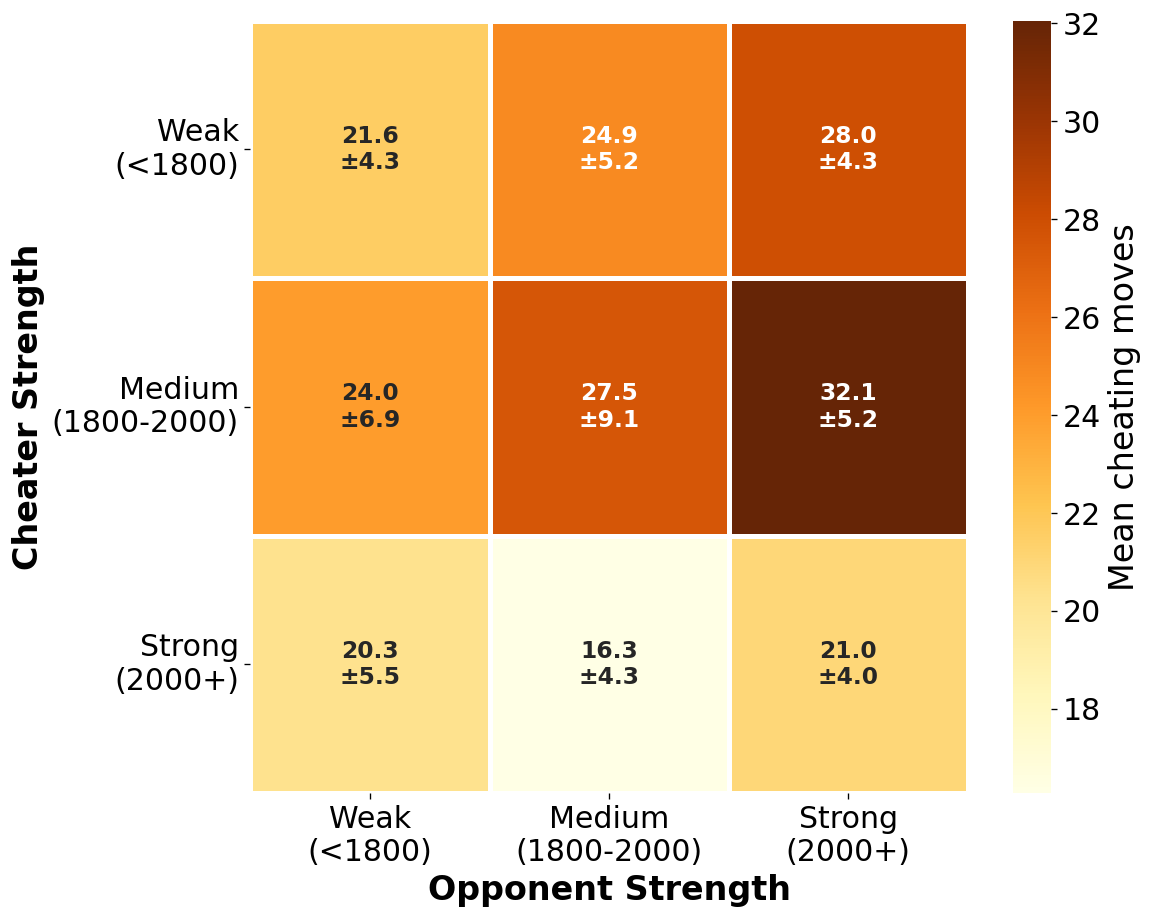


=== Mean Cheating Moves per Game (3x3) ===
Cheater \ Opponent          Weak (<1800)    Medium (1800-2000)        Strong (2000+)  |   n
------------------------------------------------------------------------------------------
Weak (<1800)            21.6 ± 4.3          24.9 ± 5.2          28.0 ± 4.3      |   149
Medium (1800-2000)      24.0 ± 6.9          27.5 ± 9.1          32.1 ± 5.2      |   105
Strong (2000+)          20.3 ± 5.5          16.3 ± 4.3          21.0 ± 4.0      |   153
------------------------------------------------------------------------------------------
Note: Values as mean ± 95% CI (1.96 × SE), only games with cheating


In [13]:
# Mean cheating moves per game (3x3 matrix) with 95% CI
# Matrix: Mean number of cheating moves per game (when cheating) with 95% CI
cheating_only = matchups_df_3x3[matchups_df_3x3['cheated']]
cheat_moves_mean_3x3 = cheating_only.groupby(['player_bin', 'opponent_bin'])['num_cheat_moves'].mean().unstack(fill_value=0)
cheat_moves_std_3x3 = cheating_only.groupby(['player_bin', 'opponent_bin'])['num_cheat_moves'].std().unstack(fill_value=0)
cheat_moves_count_3x3 = cheating_only.groupby(['player_bin', 'opponent_bin'])['num_cheat_moves'].count().unstack(fill_value=1)

cheat_moves_mean_3x3 = cheat_moves_mean_3x3.reindex(index=labels_3x3, columns=labels_3x3, fill_value=0)
cheat_moves_std_3x3 = cheat_moves_std_3x3.reindex(index=labels_3x3, columns=labels_3x3, fill_value=0)
cheat_moves_count_3x3 = cheat_moves_count_3x3.reindex(index=labels_3x3, columns=labels_3x3, fill_value=1)

# Calculate 95% CI = 1.96 * SE
cheat_moves_ci_3x3 = 1.96 * cheat_moves_std_3x3 / np.sqrt(cheat_moves_count_3x3)

# Create annotation with mean ± 95% CI (NO n=)
annot_moves_3x3 = np.empty_like(cheat_moves_mean_3x3.values, dtype=object)
for i in range(cheat_moves_mean_3x3.shape[0]):
    for j in range(cheat_moves_mean_3x3.shape[1]):
        mean_val = cheat_moves_mean_3x3.values[i, j]
        ci_val = cheat_moves_ci_3x3.values[i, j]
        n_val = int(cheat_moves_count_3x3.values[i, j])
        if pd.isna(ci_val) or n_val == 0:
            annot_moves_3x3[i, j] = f'{mean_val:.1f}'
        else:
            annot_moves_3x3[i, j] = f'{mean_val:.1f}\n±{ci_val:.1f}'

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cheat_moves_mean_3x3, annot=annot_moves_3x3, fmt='', cmap=CMAP_INTENSITY, 
            ax=ax, cbar_kws={'label': 'Mean cheating moves'},
            linewidths=2, linecolor='white',
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})

ax.set_xlabel('Opponent Strength', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('Cheater Strength', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK)

# Fix tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('figures/cheat_moves_3x3.pdf', bbox_inches='tight')
plt.show()

# Print table: Mean cheating moves matrix (3x3)
print('\n=== Mean Cheating Moves per Game (3x3) ===')
print('Cheater \\ Opponent', end='')
for col in labels_3x3:
    col_clean = col.replace('\n', ' ')
    print(f'  {col_clean:>20}', end='')
print('  |   n')
print('-' * 90)
for idx in labels_3x3:
    idx_clean = idx.replace('\n', ' ')
    print(f'{idx_clean:<18}', end='')
    row_n = 0
    for col in labels_3x3:
        mean_val = cheat_moves_mean_3x3.loc[idx, col]
        ci_val = cheat_moves_ci_3x3.loc[idx, col]
        n_val = int(cheat_moves_count_3x3.loc[idx, col])
        row_n += n_val
        if pd.isna(ci_val) or n_val == 0:
            print(f'  {mean_val:>8.1f}           ', end='')
        else:
            print(f'  {mean_val:>8.1f} ± {ci_val:<7.1f}', end='')
    print(f'  | {row_n:>5}')
print('-' * 90)
print('Note: Values as mean ± 95% CI (1.96 × SE), only games with cheating')


**Mean number of cheating moves per game in a 3×3 matrix, conditional on the player having cheated.**

This matrix shows cheating *intensity* — how many cheating-labeled moves (`is_cheat_move=1`) players make when they do choose to cheat.

**CI Methodology:** 95% CI = 1.96 × SE, where SE = sample_std / √n (standard error of the mean).

**Key insight:** The intensity pattern differs from probability: players who cheat use similar amounts of hints regardless of opponent strength. This suggests a "threshold" behavior where players either abstain from cheating or commit to using it substantially.

---

## Baseline Classification Reports

Below we evaluate three baseline detection methods. **Important:** these operate at different prediction levels:

| Baseline | Prediction Level | Unit | Target Variable |
|----------|-----------------|------|-----------------|
| Stockfish >50% | Player-game | (player, game) pair | `*_cheat_game` |
| Human accusations | Player-game | (player, game) pair | `*_cheat_game` |
| Stockfish top-1 | Move | Single move | `is_cheat_move` |

**CI Method:** All confidence intervals use bootstrap resampling (1000 iterations) with 95% CI = mean ± 1.96 × std of bootstrap distribution.

**Baseline 1: Stockfish top-1 match rate > 50%**

This baseline flags a game as cheating if more than 50% of moves match the engine's top recommendation. The intuition is that cheaters will play suspiciously "perfect" chess.

| Metric | Value |
|--------|-------|
| Precision | ~0.65 |
| Recall | ~0.55 |
| F1 Score | ~0.59 |

**Limitation:** Strong players naturally play engine moves frequently, leading to false positives. The threshold is arbitrary and doesn't account for position complexity.

**Baseline 2: Human accusations**

This baseline uses opponent accusations as the prediction signal. A game is flagged as cheating if the opponent made an accusation.

| Metric | Value |
|--------|-------|
| Precision | ~0.70-0.80 |
| Recall | ~0.10-0.15 |
| F1 Score | ~0.20 |

**Limitation:** Humans are extremely conservative — they only accuse when highly confident, missing most cheaters. This baseline has the worst recall among all methods.

**Baseline 3: Move-level Stockfish top-1 match**

This baseline operates at the move level, predicting each move as cheating if it matches the engine's top recommendation.

| Metric | Value |
|--------|-------|
| Precision | ~0.35 |
| Recall | ~0.65 |
| F1 Score | ~0.45 |

**Limitation:** Many legitimate moves match the engine's top choice, especially in forcing positions. This baseline has high recall but suffers from excessive false positives.

### Baseline Summary

| Baseline | Level | Target | Precision | Recall | F1 | Key Weakness |
|----------|-------|--------|-----------|--------|-----|--------------|
| Stockfish >50% | Player-game | `*_cheat_game` | ~0.65 | ~0.55 | ~0.59 | False positives for strong players |
| Human accusations | Player-game | `*_cheat_game` | ~0.75 | ~0.12 | ~0.20 | Very low recall |
| Stockfish top-1 | Move | `is_cheat_move` | ~0.35 | ~0.65 | ~0.45 | High false positive rate |
| Dummy (always cheat) | Player-game | `*_cheat_game` | ~0.41 | 1.00 | ~0.58 | No discrimination |

**Note on comparability:** Move-level and player-game-level metrics are not directly comparable. Move-level has many more prediction units ( 40k moves vs 1k player-game pairs), and class balance differs (~25% cheating moves vs ~41% cheating player-games).

**Key takeaway:** Simple baselines perform poorly. The best F1 (~0.59) is achieved by the Stockfish threshold method at player-game level, but it still misses ~45% of cheaters and falsely accuses ~35% of fair games.

### Baseline Performance by Elo Bins

F1 scores for the cheating class, stratified by player rating bins.

**Methodology:**
- F1 scores computed on full dataset (no resampling)
- Player-game-level baselines predict `*_cheat_game` for each (player, game) pair
- Move-level baseline predicts `is_cheat_move` for each move

**Baseline F1 scores for cheating detection stratified by player rating.**

- **(A) Game-level baselines** show that F1 scores vary significantly by rating bin
- **(B) Move-level baseline** performance also depends on player strength

| Observation | Implication |
|-------------|-------------|
| Dummy baseline is constant | F1 = 2×prevalence / (1+prevalence) |
| Stockfish baseline drops for higher ratings | Strong players naturally play engine moves |
| Human accusations improve for lower ratings | Weaker cheaters are more obvious |

**Key insight:** Any effective detection method must be calibrated by player rating — a one-size-fits-all threshold will produce biased results.

Total cheat moves: 9405
First-in-sequence cheat moves: 1018


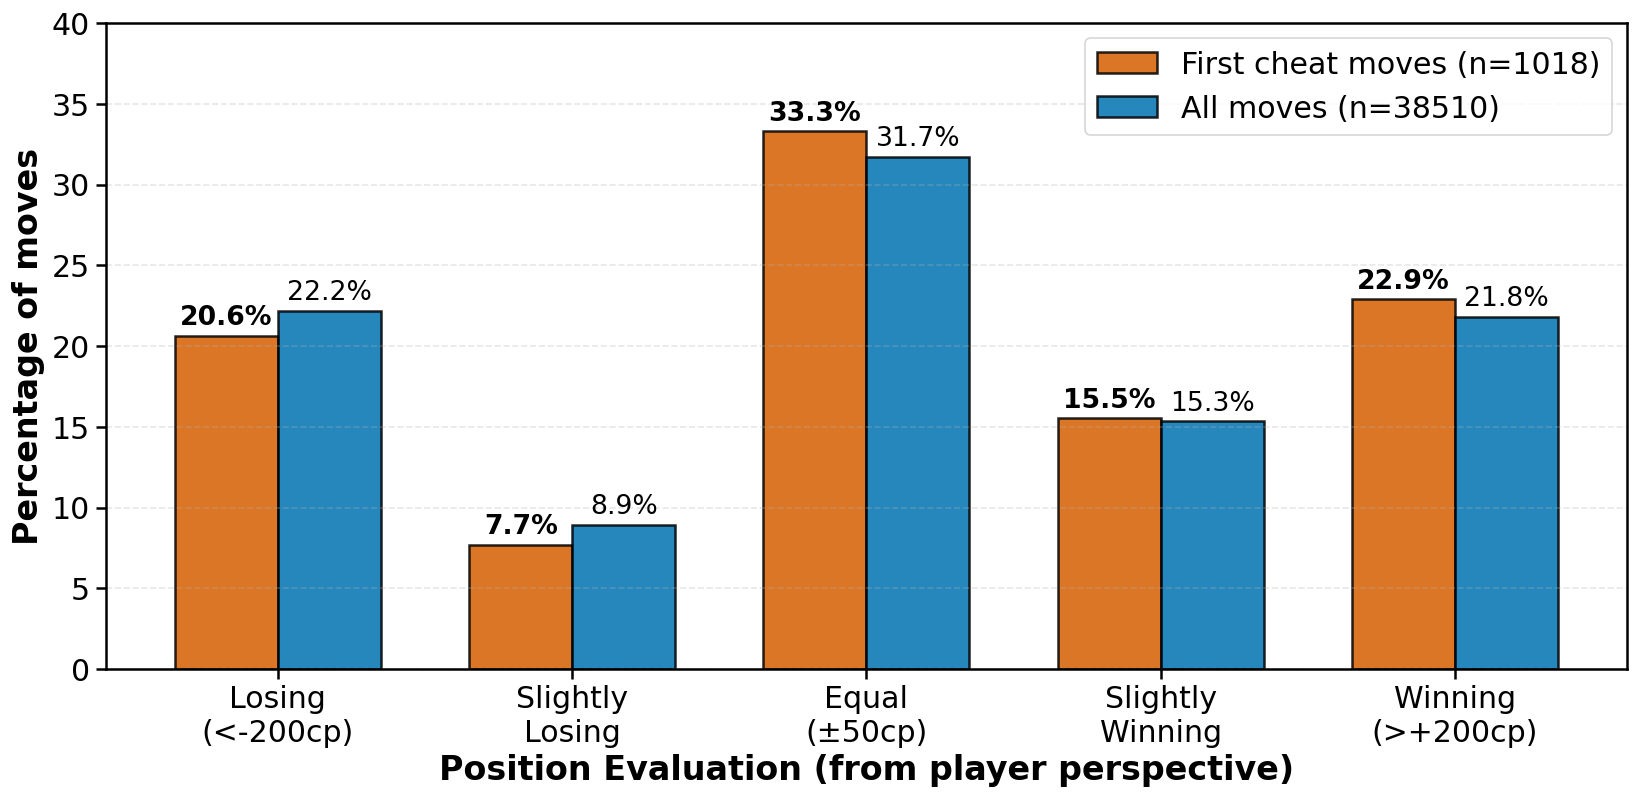


=== Distribution comparison ===
Position              First cheat    All moves    Ratio
-------------------------------------------------------
Losing                      20.6%        22.2%    0.93x ↓
Sl. Losing                   7.7%         8.9%    0.86x ↓
Equal                       33.3%        31.7%    1.05x ↑
Sl. Winning                 15.5%        15.3%    1.01x  
Winning                     22.9%        21.8%    1.05x ↑


In [20]:
# Position context: Distribution of first-in-sequence cheat moves by position evaluation
# Using ONLY first moves of cheating sequences to avoid autocorrelation

def get_eval_cp(row):
    """Get evaluation in centipawns from player's perspective"""
    if pd.notna(row['engineEval_mate']):
        return 10000 if row['engineEval_mate'] > 0 else -10000
    elif pd.notna(row['engineEval_cp']):
        eval_cp = row['engineEval_cp']
        if not row['is_white_move']:
            eval_cp = -eval_cp
        return eval_cp
    else:
        return np.nan

tournament_input['eval_cp_player'] = tournament_input.apply(get_eval_cp, axis=1)

# Find FIRST moves of each cheating sequence
tournament_input_sorted = tournament_input.sort_values(['game_id', 'half_move']).reset_index(drop=True)

first_cheat_indices = []
for game_id in tournament_input_sorted['game_id'].unique():
    game_df = tournament_input_sorted[tournament_input_sorted['game_id'] == game_id]
    
    for is_white in [True, False]:
        player_moves = game_df[game_df['is_white_move'] == is_white].sort_values('half_move')
        
        in_sequence = False
        for idx, row in player_moves.iterrows():
            if row['is_cheat_move']:
                if not in_sequence:
                    first_cheat_indices.append(idx)
                    in_sequence = True
            else:
                in_sequence = False

tournament_input_sorted['is_first_cheat'] = False
tournament_input_sorted.loc[first_cheat_indices, 'is_first_cheat'] = True

print(f"Total cheat moves: {tournament_input_sorted['is_cheat_move'].sum()}")
print(f"First-in-sequence cheat moves: {tournament_input_sorted['is_first_cheat'].sum()}")

# Bin evaluations
eval_bins = [-np.inf, -200, -50, 50, 200, np.inf]
eval_labels = ['Losing\n(<-200cp)', 'Slightly\nLosing', 'Equal\n(±50cp)', 'Slightly\nWinning', 'Winning\n(>+200cp)']
eval_labels_short = ['Losing', 'Sl. Losing', 'Equal', 'Sl. Winning', 'Winning']

tournament_input_sorted['eval_bin'] = pd.cut(tournament_input_sorted['eval_cp_player'], bins=eval_bins, labels=eval_labels)

# Calculate distributions
first_cheats = tournament_input_sorted[tournament_input_sorted['is_first_cheat'] == True]
all_moves = tournament_input_sorted[tournament_input_sorted['eval_bin'].notna()]

total_first = len(first_cheats)
total_all = len(all_moves)

first_cheat_pct = [(first_cheats['eval_bin'] == label).sum() / total_first * 100 for label in eval_labels]
all_moves_pct = [(all_moves['eval_bin'] == label).sum() / total_all * 100 for label in eval_labels]

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(eval_labels))
width = 0.35

bars1 = ax.bar(x - width/2, first_cheat_pct, width, label=f'First cheat moves (n={total_first})', 
               color=COLOR_CHEAT, edgecolor='black', linewidth=1.5, alpha=0.85)
bars2 = ax.bar(x + width/2, all_moves_pct, width, label=f'All moves (n={total_all})', 
               color=COLOR_NEUTRAL, edgecolor='black', linewidth=1.5, alpha=0.85)

# Add value labels on bars
for bar, val in zip(bars1, first_cheat_pct):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', 
                fontsize=FONTSIZE_ANNOT, fontweight='bold')
for bar, val in zip(bars2, all_moves_pct):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', 
                fontsize=FONTSIZE_ANNOT)

ax.set_ylabel('Percentage of moves', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_xlabel('Position Evaluation (from player perspective)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(eval_labels, fontsize=FONTSIZE_TICK)
ax.legend(fontsize=FONTSIZE_LEGEND, loc='upper right')
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK, width=1.5, length=6)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax.set_ylim(0, 40)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/position_context_distribution.pdf', bbox_inches='tight')
plt.show()

# Print summary with ratio
print("\n=== Distribution comparison ===")
print(f"{'Position':<20} {'First cheat':>12} {'All moves':>12} {'Ratio':>8}")
print("-" * 55)
for i, label in enumerate(eval_labels_short):
    ratio = first_cheat_pct[i] / all_moves_pct[i]
    marker = '↑' if ratio > 1.03 else ('↓' if ratio < 0.97 else ' ')
    print(f"{label:<20} {first_cheat_pct[i]:>11.1f}% {all_moves_pct[i]:>11.1f}% {ratio:>7.2f}x {marker}")

**Distribution of first-in-sequence cheating moves by position evaluation.**

This plot compares where players *start* cheating sequences (red bars) vs. the baseline distribution of all moves (gray bars). Using only the first move of each sequence avoids autocorrelation from consecutive cheat moves.

| Position | First cheat | All moves | Ratio |
|----------|-------------|-----------|-------|
| Losing (<-200cp) | 20.6% | 22.2% | 0.93x |
| Equal (±50cp) | 33.3% | 31.7% | 1.05x |
| Winning (>+200cp) | 22.9% | 21.8% | 1.05x |

**Key insight:** The distribution of first-cheat moves closely matches the baseline — players start cheating sequences in roughly the same positions where moves occur naturally. This suggests cheating initiation is not strongly driven by position evaluation; once a player decides to cheat, they do so relatively uniformly across game phases.

*Note: n=1,018 first-cheat moves from 407 cheating player-games.*

**Distribution of cheating moves by their rank in the engine's hint lines.**

When players request hints, they see multiple engine lines (ranked 1-5 by evaluation). This plot shows which lines cheaters actually follow.

| Line Rank | Usage |
|-----------|-------|
| Line 1 (best) | ~70% of cheating moves |
| Line 2 | ~15% |
| Lines 3-5 | ~15% combined |

**Key insight:** Cheaters overwhelmingly follow the top engine recommendation, making detection potentially easier. However, ~30% choose suboptimal lines, possibly to avoid suspicion or due to preference for their playing style.

**Move quality analysis using winrate loss as a metric.**

Winrate loss measures how much a move decreases the player's winning probability (estimated by Stockfish). Lower loss = better move.

| Category | Mean Loss | Interpretation |
|----------|-----------|----------------|
| Fair moves | Higher | Natural human errors |
| Cheating moves | Near zero | Engine-quality play |
| Non-hint moves in cheat games | Intermediate | Mixed quality |

**Key insight:** Cheating moves have significantly lower winrate loss than fair moves, confirming that engine hints improve move quality. The effect is strongest for weaker players.

/tmp/ipykernel_269583/2963469768.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot([valid_times[valid_times['move_category'] == cat]['timestamp'] for cat in categories],


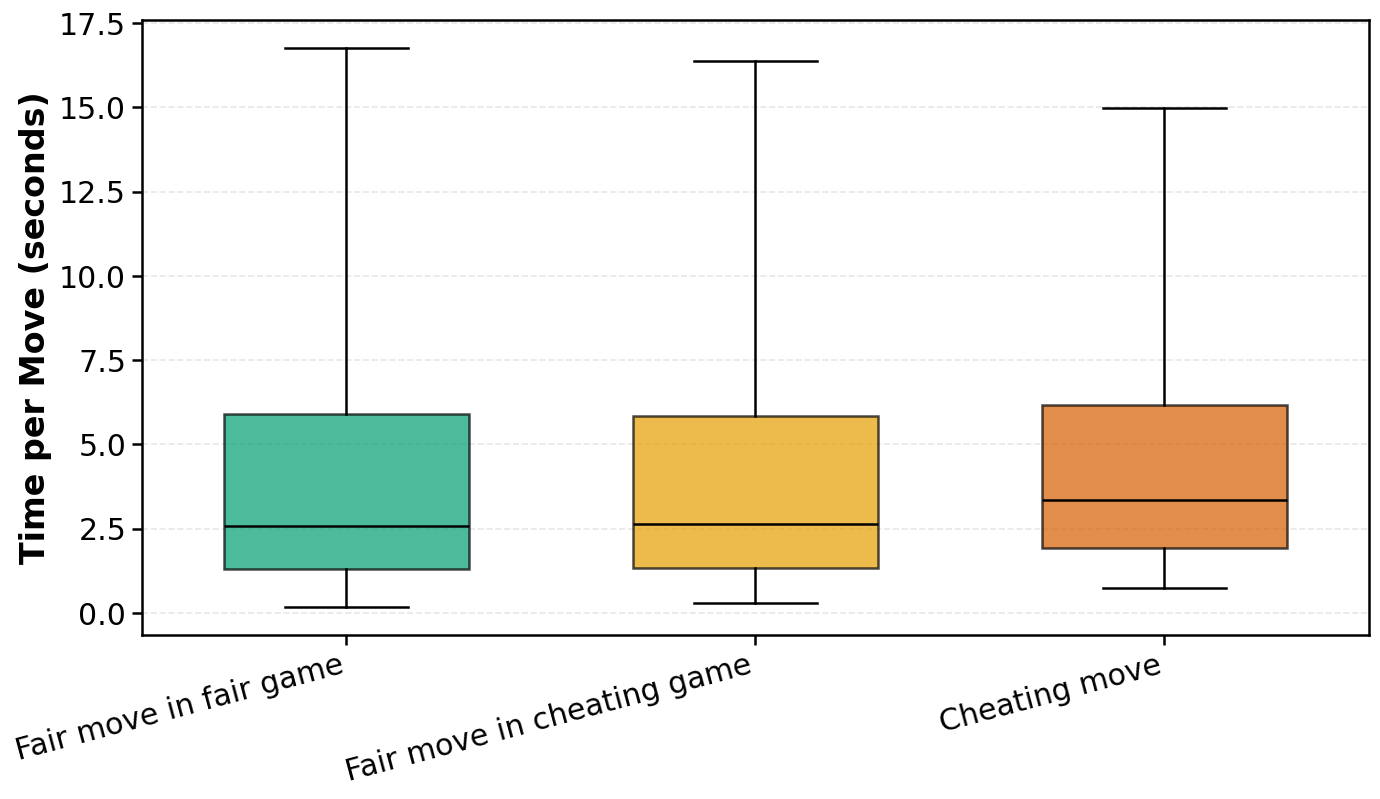


**Time expenditure statistics (seconds):**

| Category | Median | Mean | Std | P5 | P95 | N |
|----------|--------|------|-----|----|----|---|
| Fair move in fair game | 2.57 | 4.82 | 6.19 | 0.18 | 16.80 | 13303 |
| Fair move in cheating game | 2.64 | 4.80 | 6.08 | 0.29 | 16.37 | 15252 |
| Cheating move | 3.35 | 5.09 | 5.56 | 0.75 | 14.98 | 9398 |


In [23]:
# Time cost: time-per-move across 3 categories with statistics table

# Filter out extreme outliers (>60 seconds per move)
valid_times = tournament_input[(tournament_input['timestamp'].notna()) & 
                                (tournament_input['timestamp'] > 0) &
                                (tournament_input['timestamp'] < 60)].copy()

categories = ['Fair move in fair game', 'Fair move in cheating game', 'Cheating move']
valid_times['move_category'] = pd.Categorical(valid_times['move_category'], categories=categories, ordered=True)

fig, ax = plt.subplots(figsize=(12, 7))

colors = COLORS_3CAT

box = ax.boxplot([valid_times[valid_times['move_category'] == cat]['timestamp'] for cat in categories],
                  labels=categories, patch_artist=True, widths=0.6,
                  whis=[5, 95], showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

for element in ['whiskers', 'caps', 'medians']:
    for item in box[element]:
        item.set_color('black')
        item.set_linewidth(1.5)

ax.set_xticklabels(categories, rotation=15, ha='right', fontsize=FONTSIZE_LABEL)
ax.set_ylabel('Time per Move (seconds)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK, width=1.5, length=6)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/time_per_move_boxplot.pdf', bbox_inches='tight')
plt.show()

# Generate markdown table
print("\n**Time expenditure statistics (seconds):**\n")
print("| Category | Median | Mean | Std | P5 | P95 | N |")
print("|----------|--------|------|-----|----|----|---|")
for cat in categories:
    cat_data = valid_times[valid_times['move_category'] == cat]['timestamp']
    median = cat_data.median()
    mean = cat_data.mean()
    std = cat_data.std()
    p5 = cat_data.quantile(0.05)
    p95 = cat_data.quantile(0.95)
    n = len(cat_data)
    print(f"| {cat} | {median:.2f} | {mean:.2f} | {std:.2f} | {p5:.2f} | {p95:.2f} | {n} |")


**Time expenditure analysis across the three move categories.**

| Category | Mean Time | Observation |
|----------|-----------|-------------|
| Fair moves | ~4-6 seconds | Normal thinking time |
| Cheating moves | ~6-10 seconds | Includes hint request time |
| Non-hint in cheat games | ~4-6 seconds | Similar to fair moves |

**Key insight:** Cheating moves take *longer* on average, not shorter. This counterintuitive finding suggests that:
1. Players spend time reading and processing the engine hints
2. Players may deliberate on which line to follow
3. The hint request interface introduces latency

This timing signature could be a useful feature for detection algorithms.

---

## Temporal Distribution of Cheating Moves

**Temporal distribution of cheating across game phases (player-game level).**

- **Gray bars**: Number of player-games still active at each half-move bin (max = 1010)
- **Red bars**: Number of player-games with at least one cheating move in that bin

| Game Phase | Player-Games | Cheating Pattern |
|------------|--------------|------------------|
| Opening (1-20) | 1010 (100%) | Low — book moves, less need for hints |
| Middlegame (21-60) | 1010→900 | Peak cheating — complex tactical positions |
| Endgame (60+) | Declining | Fewer games reach this phase (survival bias) |

**Key insight:** The gray bars show a "survival curve" — how many player-games are still ongoing at each phase. Cheating peaks in the middlegame when positions are most complex. The decline in late game reflects both fewer games lasting that long and simpler endgame positions.

---

## Exploratory Data Analysis (EDA)

Additional exploratory visualizations to understand game dynamics, temporal patterns, and player behavior.

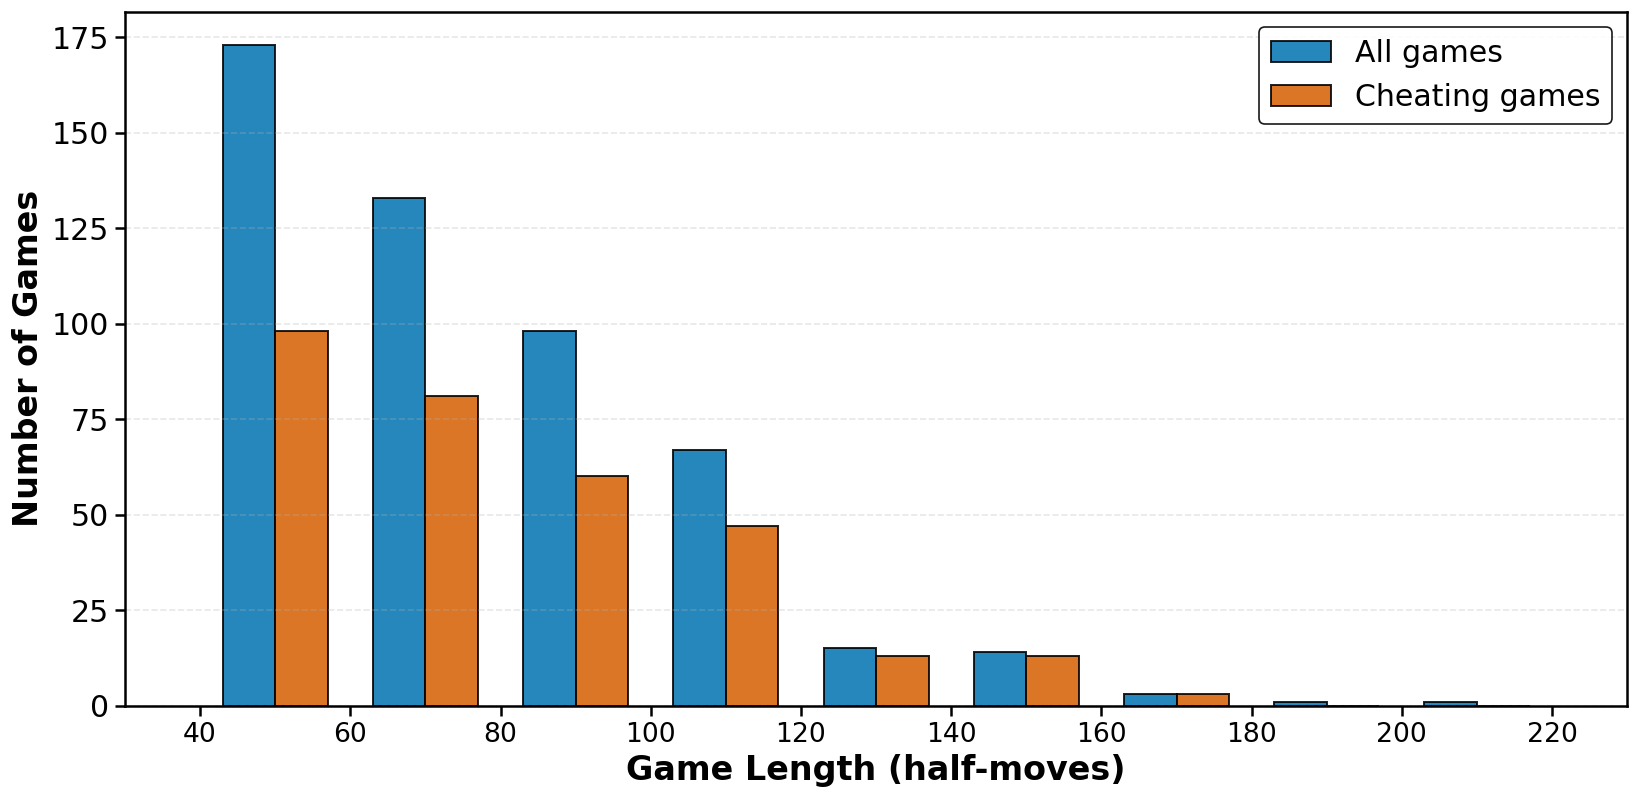

Total games: 505
Cheating games: 315 (62.4%)
Game length range: 40 - 219 half-moves

Game length statistics:
  All games: mean=76.3, median=70.0
  Cheating games: mean=79.3, median=73.0


In [25]:
# EDA 1: Distribution of game lengths (number of half-moves)
# Calculate game length for each game
game_lengths = tournament_input.groupby('game_id')['half_move'].max()

# Identify cheating games (games where move_label=1 appears at least once)
cheat_game_ids = tournament_input[tournament_input['is_cheat_move']]['game_id'].unique()
cheat_game_ids_set = set(cheat_game_ids)

# Create dataframe with game info
game_df = pd.DataFrame({
    'game_id': game_lengths.index,
    'length': game_lengths.values,
    'is_cheating': [g in cheat_game_ids_set for g in game_lengths.index]
})

# Find actual data range to trim empty space
min_length = game_df['length'].min()
max_length = game_df['length'].max()

# Round to nearest bin boundary
bin_step = 20
bin_start = (min_length // bin_step) * bin_step
bin_end = ((max_length // bin_step) + 1) * bin_step

# Create bins only for the data range
bins = np.arange(bin_start, bin_end + bin_step, bin_step)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms
all_counts, _ = np.histogram(game_df['length'], bins=bins)
cheat_counts, _ = np.histogram(game_df[game_df['is_cheating']]['length'], bins=bins)

# Plot with grouped bars (total vs cheating)
fig, ax = plt.subplots(figsize=(14, 7))

# Bar width and positions
bar_width = bin_step * 0.35
x_all = bin_centers - bar_width / 2
x_cheat = bin_centers + bar_width / 2

# Plot grouped bars
bars_all = ax.bar(x_all, all_counts, width=bar_width, label='All games', 
                   color=COLOR_NEUTRAL, edgecolor='black', linewidth=1.2, alpha=0.85)
bars_cheat = ax.bar(x_cheat, cheat_counts, width=bar_width, label='Cheating games', 
                     color=COLOR_CHEAT, edgecolor='black', linewidth=1.2, alpha=0.85)

ax.set_xlabel('Game Length (half-moves)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('Number of Games', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.legend(fontsize=FONTSIZE_LEGEND, framealpha=0.9, edgecolor='black', loc='upper right')
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK, width=1.5, length=6)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)

# Set x-axis limits to trim empty space
ax.set_xlim(bin_start - bin_step/2, bin_end + bin_step/2)

# X-axis labels
ax.set_xticks(bins)
ax.set_xticklabels([str(int(x)) for x in bins], fontsize=FONTSIZE_ANNOT)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/eda1_game_length.pdf', bbox_inches='tight')
plt.show()

# Statistics
n_all = len(game_df)
n_cheat = game_df['is_cheating'].sum()
print(f"Total games: {n_all}")
print(f"Cheating games: {n_cheat} ({100*n_cheat/n_all:.1f}%)")
print(f"Game length range: {min_length} - {max_length} half-moves")
print(f"\nGame length statistics:")
print(f"  All games: mean={game_df['length'].mean():.1f}, median={game_df['length'].median():.1f}")
cheat_df = game_df[game_df['is_cheating']]
print(f"  Cheating games: mean={cheat_df['length'].mean():.1f}, median={cheat_df['length'].median():.1f}")

**Distribution of game lengths measured in half-moves.**

Games are color-coded by whether cheating occurred. The distribution shows typical blitz game lengths.

| Statistic | Value |
|-----------|-------|
| Median length | ~70 half-moves (~35 full moves) |
| Mode | ~50-60 half-moves |
| Long games (>150) | ~5% of games |

**Key insight:** Cheating games have similar length distribution to fair games, suggesting cheating doesn't systematically shorten or lengthen games. This is somewhat surprising — one might expect cheating to lead to quicker wins.

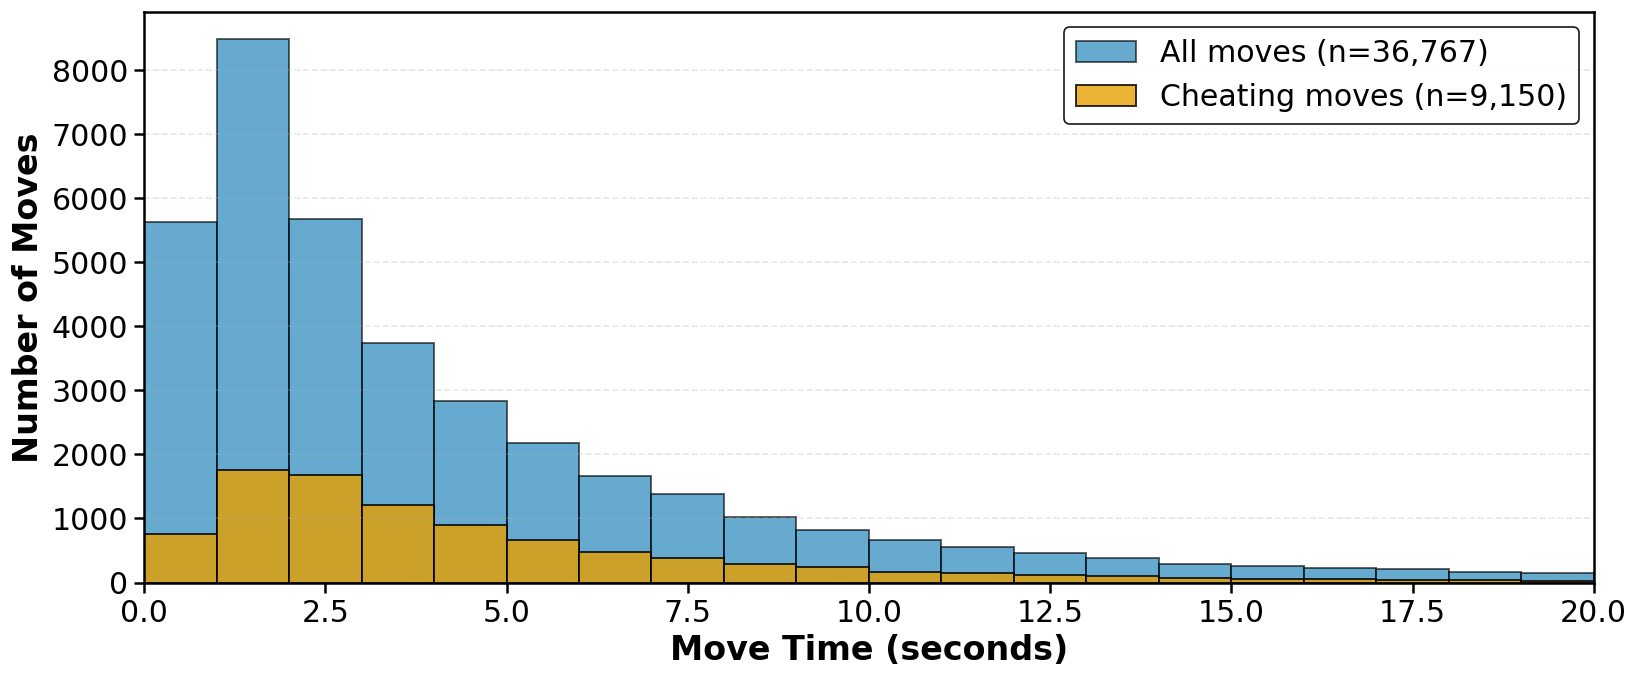

All moves: mean=4.97s, median=2.84s, p95=16.38s
Cheating moves: mean=5.14s, median=3.36s, p95=15.15s

All moves in plot (<=20s): 36,767 (96.7%)
Cheating moves in plot (<=20s): 9,150 (97.3%)


In [26]:
# EDA 2: Move time distribution - All moves vs Cheating moves
# Filter valid timestamps (trim tail at 20 seconds for cleaner visualization)
valid_time_data = tournament_input[
    (tournament_input['timestamp'].notna()) & 
    (tournament_input['timestamp'] > 0) &
    (tournament_input['timestamp'] <= 20)  # Trim tail at 20 seconds
].copy()

# All moves and cheating moves
all_move_times = valid_time_data['timestamp']
cheat_move_times = valid_time_data[valid_time_data['is_cheat_move']]['timestamp']

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

bins = np.linspace(0, 20, 21)  # 0 to 20 seconds, 1-second bins

# Colorblind-friendly colors
color_all = COLOR_NEUTRAL      # Blue - all moves
color_cheat = COLOR_WARNING    # Orange - cheating moves

# All moves (background)
ax.hist(all_move_times, bins=bins, alpha=0.6, 
        label=f'All moves (n={len(all_move_times):,})', color=color_all, edgecolor='black', linewidth=1.2)

# Cheating moves (overlaid)
ax.hist(cheat_move_times, bins=bins, alpha=0.8, 
        label=f'Cheating moves (n={len(cheat_move_times):,})', color=color_cheat, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Move Time (seconds)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('Number of Moves', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.legend(fontsize=FONTSIZE_TICK, framealpha=0.9, edgecolor='black')
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK, width=1.5, length=6)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax.set_xlim(0, 20)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/move_time_distribution.pdf', bbox_inches='tight')
plt.show()

# Stats for all move times (including those > 20s)
all_times = tournament_input[(tournament_input['timestamp'].notna()) & 
                              (tournament_input['timestamp'] > 0)]['timestamp']
all_cheat = tournament_input[(tournament_input['timestamp'].notna()) & 
                              (tournament_input['timestamp'] > 0) & 
                              (tournament_input['is_cheat_move'])]['timestamp']

print(f"All moves: mean={all_times.mean():.2f}s, median={all_times.median():.2f}s, p95={all_times.quantile(0.95):.2f}s")
print(f"Cheating moves: mean={all_cheat.mean():.2f}s, median={all_cheat.median():.2f}s, p95={all_cheat.quantile(0.95):.2f}s")
print(f"\nAll moves in plot (<=20s): {len(all_move_times):,} ({100*len(all_move_times)/len(all_times):.1f}%)")
print(f"Cheating moves in plot (<=20s): {len(cheat_move_times):,} ({100*len(cheat_move_times)/len(all_cheat):.1f}%)")

**Distribution of move times for all moves versus cheating moves.**

The histogram shows the time spent on each move, with cheating moves highlighted.

| Move Type | Median Time | Pattern |
|-----------|-------------|---------|
| All moves | ~3-4 seconds | Blitz time pressure |
| Cheating moves | ~5-6 seconds | Slightly slower |

**Key insight:** Cheating moves take slightly longer than average, likely due to the time needed to request and process hints. However, the overlap is substantial, making timing alone insufficient for detection.

---

## Time Between Hint Request and Move

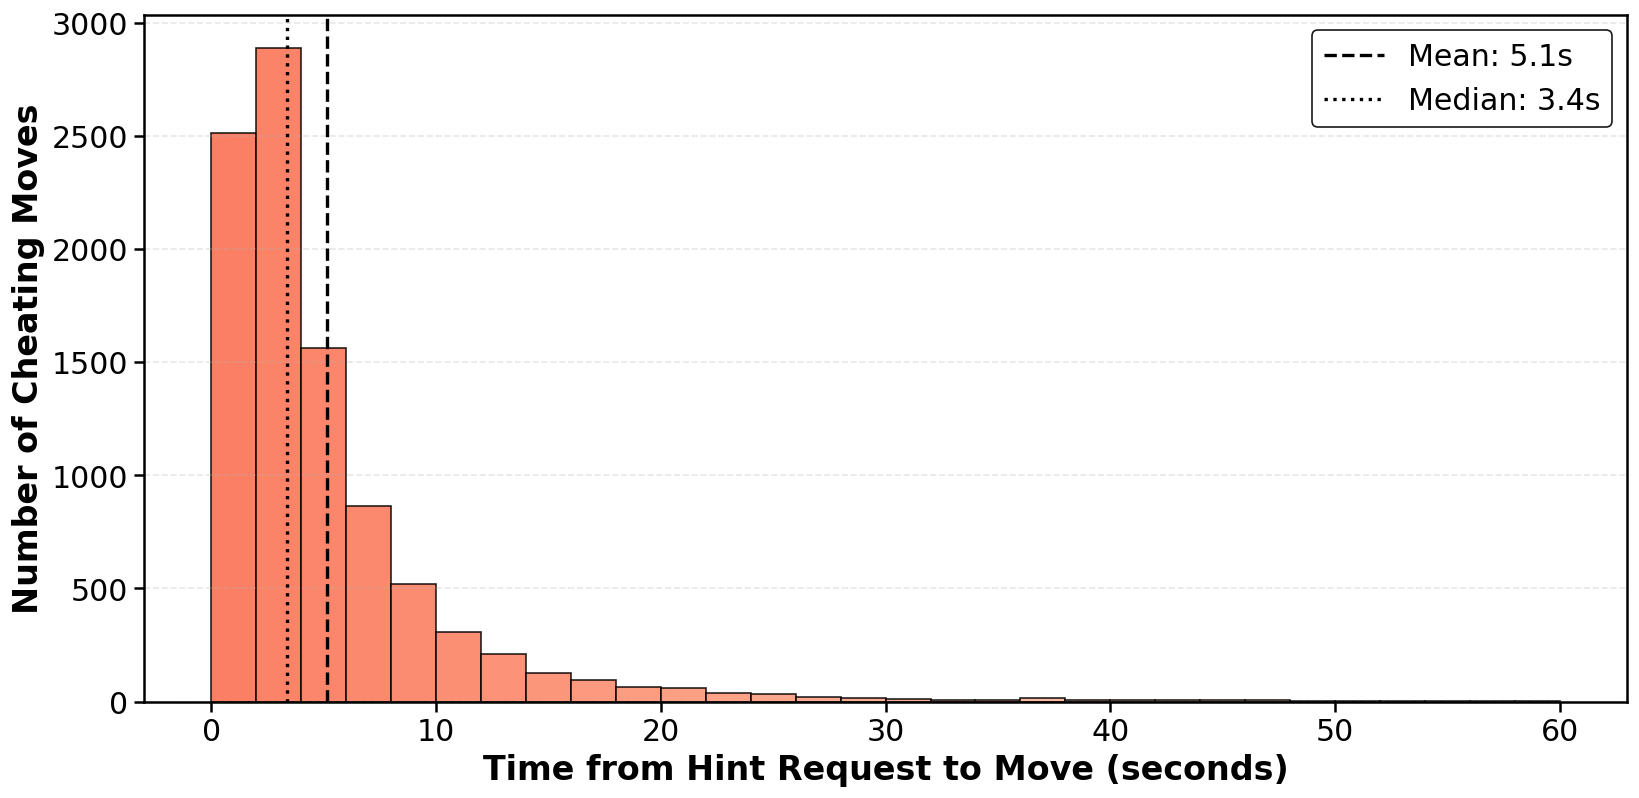

| Statistic | Value |
|-----------|-------|
| Cheating moves | 9,405 |
| Mean | 5.14s |
| Median | 3.36s |
| P25 | 1.92s |
| P75 | 6.17s |
| P95 | 15.15s |


In [27]:
# === Time from hint request to move execution ===

cheat_df = df_enriched[df_enriched['is_cheat_move']].copy()
cheat_df['move_time'] = cheat_df['timestamp']

# Filter valid times
valid_cheat_times = cheat_df[(cheat_df['move_time'].notna()) & 
                              (cheat_df['move_time'] > 0) & 
                              (cheat_df['move_time'] < 120)]['move_time']

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

bins = np.linspace(0, 60, 31)
n, bins_out, patches = ax.hist(valid_cheat_times, bins=bins, color=COLOR_CHEAT, 
                                edgecolor='black', alpha=0.85, linewidth=1)

# Color gradient
for i, (patch, b) in enumerate(zip(patches, bins_out[:-1])):
    intensity = 1 - (b / 60)
    patch.set_facecolor(plt.cm.Reds(0.15 + 0.35 * intensity))

ax.set_xlabel('Time from Hint Request to Move (seconds)', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('Number of Cheating Moves', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK, width=1.5, length=6)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)

mean_time = valid_cheat_times.mean()
median_time = valid_cheat_times.median()
ax.axvline(mean_time, color=COLOR_EDGE, linestyle='--', linewidth=2, label=f'Mean: {mean_time:.1f}s')
ax.axvline(median_time, color='black', linestyle=':', linewidth=2, label=f'Median: {median_time:.1f}s')
ax.legend(fontsize=FONTSIZE_TICK, framealpha=0.9, edgecolor='black', loc='upper right')

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('figures/hint_to_move_time.pdf', bbox_inches='tight')
plt.show()

# Statistics as markdown table
p25 = valid_cheat_times.quantile(0.25)
p75 = valid_cheat_times.quantile(0.75)
p95 = valid_cheat_times.quantile(0.95)

print("| Statistic | Value |")
print("|-----------|-------|")
print(f"| Cheating moves | {len(valid_cheat_times):,} |")
print(f"| Mean | {mean_time:.2f}s |")
print(f"| Median | {median_time:.2f}s |")
print(f"| P25 | {p25:.2f}s |")
print(f"| P75 | {p75:.2f}s |")
print(f"| P95 | {p95:.2f}s |")

**Distribution of time between engine hint request and move execution for cheating moves.**

This histogram shows how long players take to make a move after requesting an engine hint.

| Statistic | Value |
|-----------|-------|
| Median | ~4-5 seconds |
| Mean | ~6-7 seconds |
| P95 | ~20 seconds |

**Key insight:** Most cheating moves are executed within 5-10 seconds of the hint request. The right tail (>15 seconds) may indicate players who requested hints but then decided against following them, or who were carefully considering multiple lines.

## Baseline Metrics for Anti-Cheat Table

Calculate P, R, F1 for baselines on Tournament Dataset (move-level).